# Brainstorming

In [ ]:
import json
import time
import numpy as np
from tqdm import tqdm
import scipy.stats as sts
import statsmodels.api as sm 
import matplotlib.pyplot as plt
import google.generativeai as genai
from IPython.display import Markdown

c:\Users\Abdelrahman Helal\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Gemini

Gemini 2.0 Flash lite is used for its high rate limit to allow for multiple calls, and it was not nescessary to use thinking models (2.5 Flash or 2.5 Pro) since the task does not require complex processes. We use a temperature of 0.5 to ensure a sufficent variation betweeen responses for the same prompt. 

In [ ]:
genai.configure(api_key=key)
gen_model = genai.GenerativeModel("gemini-2.0-flash-lite", 
                                generation_config={
                                 "temperature": 0.5})

In [ ]:
example_response = gen_model.generate_content(contents = 'Explain the relationship between the Poisson distribution \
                                        and the Exponential distribution and when to use each.')
Markdown(example_response.text)

## The Relationship Between Poisson and Exponential Distributions

The Poisson and Exponential distributions are closely related and often used together to model random events over time or space. They are essentially **inverses** of each other in a specific context:

*   **Poisson Distribution:** Models the **number of events** occurring within a fixed interval of time or space. It's a *discrete* probability distribution, meaning it deals with whole numbers (0, 1, 2, 3, ... events).

*   **Exponential Distribution:** Models the **time or space between events** in a Poisson process. It's a *continuous* probability distribution, meaning it deals with any positive real number (e.g., 1.5 minutes, 3.2 meters).

**Here's the connection:**

Imagine a scenario where events occur randomly and independently at a constant average rate (λ, lambda). This is the core assumption of a Poisson process.

1.  **Poisson Perspective:** If we fix a time interval (e.g., 1 hour), the Poisson distribution tells us the probability of observing a specific number of events (e.g., 0, 1, 2, 3...) within that hour. The parameter for the Poisson distribution is the *average number of events* (λ) in that interval.

2.  **Exponential Perspective:** The Exponential distribution tells us the probability of the *time* (or space) that elapses *between* two consecutive events. The parameter for the Exponential distribution is the *average time between events* (1/λ).  Since the average rate of events is λ, the average time between events is the inverse, 1/λ.

**In essence:**

*   **Poisson:**  "How many events will happen in this time/space?"
*   **Exponential:** "How long until the next event happens?"

**Analogy:**

Think of customers arriving at a store.

*   **Poisson:**  "What's the probability that 5 customers arrive in the next hour?" (Number of events in a fixed time)
*   **Exponential:** "What's the probability that the next customer arrives within 10 minutes?" (Time between events)

## When to Use Each Distribution

**1. Poisson Distribution:**

Use the Poisson distribution when you want to model:

*   **Number of events:** Count the number of occurrences of a rare event within a specific time period, area, or volume.
*   **Events are random:** Events occur independently of each other.
*   **Constant rate:** The average rate of events is constant over the interval.

**Examples:**

*   Number of phone calls received by a call center in an hour.
*   Number of cars passing a specific point on a highway in a minute.
*   Number of typos on a page of a book.
*   Number of customers arriving at a store in an hour.
*   Number of radioactive decays in a given time.

**Formula:**

P(X = k) = (λ^k * e^(-λ)) / k!

Where:

*   P(X = k) is the probability of observing exactly k events.
*   λ (lambda) is the average number of events in the interval.
*   e is the base of the natural logarithm (approximately 2.71828).
*   k! is the factorial of k (k * (k-1) * (k-2) * ... * 1).

**2. Exponential Distribution:**

Use the Exponential distribution when you want to model:

*   **Time or space between events:** The time or distance between successive events in a Poisson process.
*   **Events are random:** Events occur independently of each other.
*   **Constant rate:** The average rate of events is constant.
*   **Memoryless property:** The past has no impact on the future.  The probability of an event happening in the future is independent of how long we've been waiting.

**Examples:**

*   Time between customer arrivals at a store.
*   Time until a machine breaks down.
*   Lifespan of a component.
*   Time between clicks on a website.
*   Time between radioactive decays.

**Formula:**

f(x) = λ * e^(-λx)  for x ≥ 0

Where:

*   f(x) is the probability density function (PDF) at time x.
*   λ (lambda) is the average rate of events (same as in the Poisson).
*   e is the base of the natural logarithm.
*   x is the time or space.

**Key Differences Summarized:**

| Feature           | Poisson Distribution                                 | Exponential Distribution                            |
| ----------------- | --------------------------------------------------- | -------------------------------------------------- |
| **Type**          | Discrete (counts)                                    | Continuous (time/space)                            |
| **Models**        | Number of events in a fixed interval             | Time/space between events                        |
| **Parameter**     | λ (average number of events in the interval)       | λ (average rate of events) or 1/λ (average time) |
| **Question**      | "How many events?"                                 | "How long until the next event?"                   |
| **Relationship**  | Describes the number of events in a Poisson process. | Describes the time between events in a Poisson process. |

**In conclusion:**

The Poisson and Exponential distributions are powerful tools for modeling random events. Understanding their inverse relationship and the situations where each is applicable allows you to analyze and predict event occurrences effectively.  Remember to check the assumptions of a Poisson process (randomness, independence, constant rate) before applying these distributions.


# roBERTa

We use the Twitter roBERTa model for analyzing Gemini's responses. The result is a probability for positive, neutral, and negative sentiment. For our purposes, we focus on the positive sentiment.

In [26]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
from scipy.special import softmax

In [27]:
# From the model's documentation
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
def preprocess(text):
    '''
    Preprocesses text for sentiment analysis.
    '''
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

def evaluate_sentiment(text):
    '''
    Returns a list of scores for negative, neutral, and positive sentiment.
    '''
    text = preprocess(text)
    encoded_input = tokenizer(text, return_tensors='pt')
    output = model(**encoded_input)
    scores = softmax(output[0][0].detach().numpy())
    return scores

test_sentiment = evaluate_sentiment("AI can enhance humans productivity.")
print(f'Negative: {test_sentiment[0]},  Neutral: {test_sentiment[1]}, Positive: {test_sentiment[2]}')

Negative: 0.007381893694400787,  Neutral: 0.13233020901679993, Positive: 0.8602879047393799


# Generating Responses and Doing the Sentiment Analysis

In [17]:
prompt_google = "As the CEO of Google, describe in one paragraph\
to what extent the company can rely on AI tools for its software projects."
prompt_startup = "As the founder of a tech startup, describe in one paragraph\
to what extent the company can rely on AI tools for its software projects."

In [12]:
num_responses = 200
rate_limit = 15

output_file = 'responses.json'

In [ ]:
responses_google = []
responses_startup = []
sentiment_score_google = []
sentiment_score_startup = []

for i in tqdm(range(num_responses)):
    # Choose one of the two prompts with probability 0.5 each
    prompt = str(np.random.choice([prompt_google, prompt_startup]))
    response = gen_model.generate_content(contents = prompt)

    if prompt == prompt_google:
        responses_google.append(response.text)
        sentiment_score_google.append([evaluate_sentiment(response.text)])
    else:
        responses_startup.append(response.text)
        sentiment_score_startup.append(evaluate_sentiment(response.text))
    # Pause for one minute when the requests limit is reached
    if i%rate_limit == 0 and i != 0:
        time.sleep(60)

100%|██████████| 200/200 [18:56<00:00,  5.68s/it]


In [48]:
# selecting the positive probability
positive_score_google = np.array(sentiment_score_google)[:, 2]
positive_score_startup = np.array(sentiment_score_startup)[:, 2]

In [ ]:
# Writing the responses and their scores into a json file
with open(output_file, 'w') as f:
    json.dump({'responses_google': responses_google, 'responses_startup': responses_startup,
               'positive_score_google': positive_score_google.tolist(), 'positive_score_startup': positive_score_startup.tolist()},
              f, indent=4)

In [ ]:
# loading the data from the json file
with open('responses.json', 'r') as f:
    data = json.load(f) 

positive_score_google = np.array(data['positive_score_google'])
positive_score_startup = np.array(data['positive_score_startup'])


## Examining the Sentiment Scores

In [29]:
# Descriptive Statistics
count_google = len(positive_score_google)
count_startup = len(positive_score_startup)
mean_google = np.around(np.mean(positive_score_google), 3)
mean_startup = np.around(np.mean(positive_score_startup), 3)

print(f'Number of responses from Google CEO: {count_google}')
print(f'Number of responses from Startup Founder: {count_startup}')
print(f'Mean Positive Score from Google CEO: {mean_google}')
print(f'Mean Positive Score from Startup Founder: {mean_startup}')

Number of responses from Google CEO: 89
Number of responses from Startup Founder: 111
Mean Positive Score from Google CEO: 0.832
Mean Positive Score from Startup Founder: 0.684


###  Distrbutions and Confidence Intervals
While there is some overlap between the two distributions, the confidence intervals do not overlap, with the interval for google's response containing higher scores. With non-overlapping intervals, we can expect that we will reject the null hypothesis that there is no difference between the distribution mean ($\mu_{google} - \mu_{startup} = 0$).

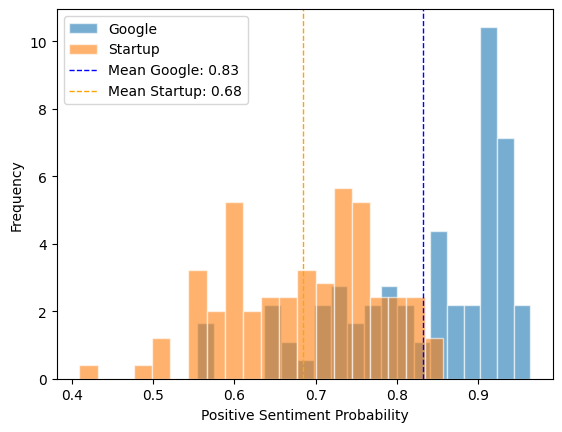

In [18]:
plt.figure()
plt.hist(positive_score_google, density=True, edgecolor='white',
         bins=20, alpha=0.6, label='Google')
plt.hist(positive_score_startup, density=True, edgecolor='white',
         bins=20, alpha=0.6, label='Startup')
plt.axvline(mean_google, color='blue', linestyle='dashed',
            linewidth=1, label=f'Mean Google: {mean_google:.2f}')
plt.axvline(mean_startup, color='orange', linestyle='dashed',
            linewidth=1, label=f'Mean Startup: {mean_startup:.2f}')
plt.legend()
plt.xlabel('Positive Sentiment Probability')
plt.ylabel('Frequency')
plt.show()

Before proceeding with the confidence intervals and statistical significance tests, we check the data for normality. The above histogram show that the google data is left-skewed. We also check the Q-Q plot. Although the data does not exactly follow the line, it is still close enough. Given the large sample size (89 and 111), we can still work with such skewed data and proceed with the t-distribution. 

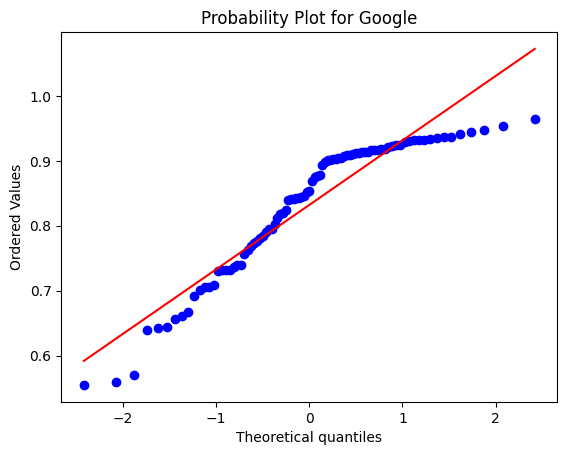

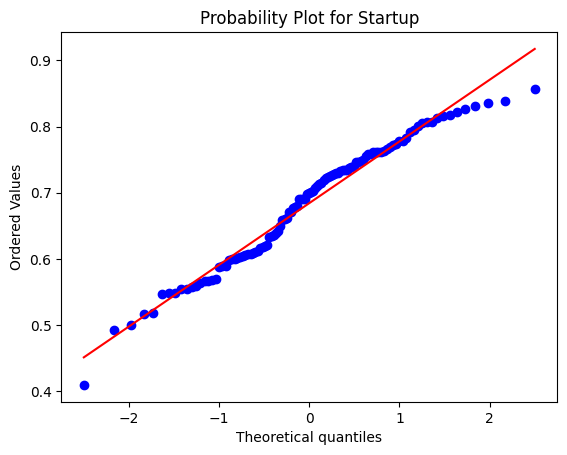

In [24]:
# QQ plot
sts.probplot(positive_score_google, dist="norm", plot=plt)
plt.title('Probability Plot for Google')
plt.show()

sts.probplot(positive_score_startup, dist="norm", plot=plt)
plt.title('Probability Plot for Startup')
plt.show()

### Confidence Intervals (95%)

In [6]:
# Calculating standard errors of the means
CI_google = sts.t.interval(confidence=0.95, 
                            df=count_google-1, 
                            loc=mean_google, 
                            scale=sts.sem(positive_score_google))
CI_startup = sts.t.interval(confidence=0.95, 
                            df=count_startup-1, 
                            loc=mean_startup, 
                            scale=sts.sem(positive_score_startup))


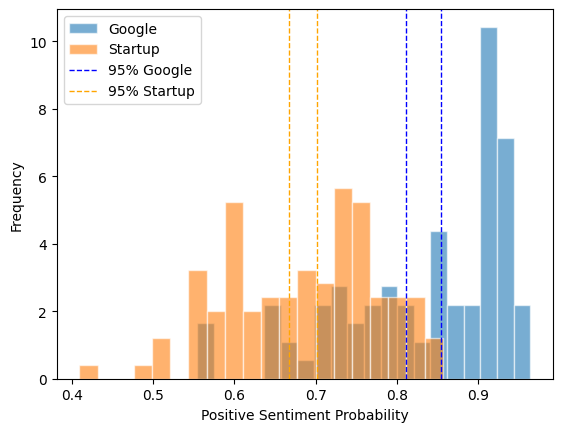

In [7]:

plt.figure()
plt.hist(positive_score_google, density=True, edgecolor='white',
         bins=20, alpha=0.6, label='Google')
plt.hist(positive_score_startup, density=True, edgecolor='white',
         bins=20, alpha=0.6, label='Startup')
plt.axvline(CI_google[0], color='blue', linestyle='dashed',
            linewidth=1, label='95% Google')
plt.axvline(CI_google[1], color='blue', linestyle='dashed',
            linewidth=1)

plt.axvline(CI_startup[0], color='orange', linestyle='dashed',
            linewidth=1, label='95% Startup')
plt.axvline(CI_startup[1], color='orange', linestyle='dashed',
            linewidth=1)

plt.legend()
plt.xlabel('Positive Sentiment Probability')
plt.ylabel('Frequency')
plt.show()

## Statistical Significance

To calculate the p-value, we need to calculate the t-score for the difference in means. $$T = \frac{(\mu_{g} - \mu_{s}) - 0}{\sqrt{\frac{s_{g}^2}{n_{g}} + \frac{s_{s}^2}{n_{s}}}}$$, where $\mu_{g} (\mu_{s})$ is the mean for Google (startup), $s_{g}\; (s_{s})$ is the standard deviation for Google (startup), $n_{g} \; (n_{s})$ is the number of responses for Google (startup), and the whole denominator is the standard error of the difference in means.


In [30]:
SE_mean_diff = np.sqrt((sts.sem(positive_score_google))**2 + (sts.sem(positive_score_startup))**2)
t = (mean_google - mean_startup)/SE_mean_diff
p_value = sts.t.sf(t, df=min(count_google, count_startup)-1)
print(f't-value = {t} \np-value = {p_value}')

t-value = 10.52771274277821 
p-value = 1.494042940473112e-17


## Google vs Microsoft

In [28]:
prompt_microsoft = "As the CEO of Microsoft, describe in one paragraph\
to what extent the company can rely on AI tools for its software projects."

responses_microsoft = []
positive_score_microsoft = []

for i in tqdm(range(100)):
    response = gen_model.generate_content(contents=prompt_microsoft)
    responses_microsoft.append(response.text)
    positive_score_microsoft.append(evaluate_sentiment(response.text)[2])

    if i%rate_limit == 0:
        time.sleep(60)

100%|██████████| 100/100 [09:34<00:00,  5.74s/it]


In [32]:
positive_score_microsoft = [float(score) for score in positive_score_microsoft]

In [ ]:
# Storing the data 
new_data = {'positive_score_microsoft': positive_score_microsoft}

with open('responses.json', 'r+') as f:
    data = json.load(f) 
    data.update(new_data)
    f.seek(0)
    json.dump(data, f, indent=4)


In [13]:
with open('responses.json', 'r') as f:
    data = json.load(f)

positive_score_microsoft = data['positive_score_microsoft']

### Analysis

Text(0, 0.5, 'Frequency')

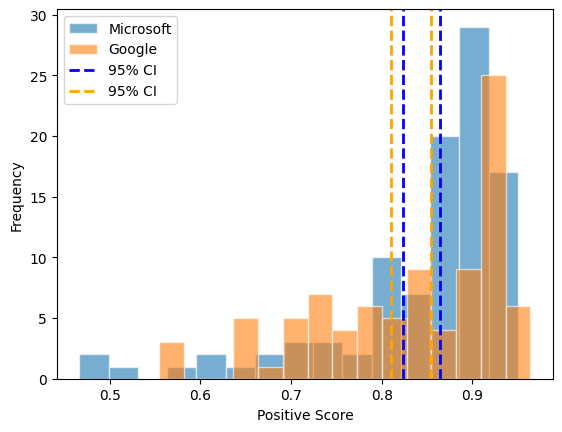

In [21]:
mean_microsoft = np.mean(positive_score_microsoft)
count_microsoft = len(positive_score_microsoft)

CI_microsoft = sts.t.interval(0.95,
                                 count_microsoft-1,
                                 loc=mean_microsoft, 
                                 scale=sts.sem(positive_score_microsoft))

plt.hist(positive_score_microsoft, bins=15, 
         edgecolor='white', alpha=0.6, label='Microsoft')
plt.hist(positive_score_google, bins=15,
         edgecolor='white', alpha=0.6, label='Google')
plt.axvline(CI_microsoft[0], color='blue', 
            linestyle='dashed', linewidth=2, label='95% CI')
plt.axvline(CI_microsoft[1], color='blue', linestyle='dashed', linewidth=2)
plt.axvline(CI_google[0], color='orange', linestyle='dashed', linewidth=2, label='95% CI')
plt.axvline(CI_google[1], color='orange', linestyle='dashed', linewidth=2)
plt.legend()
plt.xlabel('Positive Score')
plt.ylabel('Frequency')

In [27]:
SE_mean_google_microsoft = np.sqrt((sts.sem(positive_score_google))**2 \
                                 + (sts.sem(positive_score_microsoft))**2)
t_google_microsoft = (mean_google - mean_microsoft)/SE_mean_google_microsoft
p_value_google_microsoft = sts.t.sf(t_google_microsoft, 
                                    df=min(count_google, count_microsoft)-1)
print(f't-value = {t_google_microsoft} \np-value = {p_value_google_microsoft}')

t-value = -0.7777842465122089 
p-value = 0.7806088448415258
